# Dependencies installation
we'll first try to fetch a pre-installed dependencies from google-drive, if it doesn't exist, we'll install it there for faster loading next *time*

In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np

from src import multi_run
from src.channel_simulation import ChannelSimulator
from src.split_step_fourier import SplitStepFourier
from src.visualizer import Visualizer

/Users/yarden/Desktop/thesis_stuff/Thesis-code/src/split_step_fourier.py:27: UserWarning: there are not enough (0) steps in split algo do at least one of the following: 
	1) reduce h
	2) enlarge t0
	3) enlarge last step

  warnings.warn(f"there are not enough ({self.N}) steps in split algo do at least one of the following: \n"


# Deep Learning research

## BER vs normalization factor

number of iterations in split step algo: 15
normalizing factors are: [3.16e-04 1.39e-03 6.11e-03 2.68e-02 1.18e-01 5.18e-01 2.28e+00 1.00e+01]


100%|██████████| 24/24 [00:02<00:00, 11.64it/s]


64 symbols: errors found = [  0   0   0 116 401 383 383 385] / [768 = 256 bits * 3 realisations]


100%|██████████| 24/24 [00:04<00:00,  5.52it/s]


128 symbols: errors found = [  0   0   0 431 804 756 750 739] / [1536 = 512 bits * 3 realisations]


100%|██████████| 24/24 [00:10<00:00,  2.27it/s]


256 symbols: errors found = [   0    0    4 1419 1541 1561 1508 1538] / [3072 = 1024 bits * 3 realisations]


100%|██████████| 24/24 [00:22<00:00,  1.08it/s]


512 symbols: errors found = [   0    0   52 3203 3053 3051 2986 3034] / [6144 = 2048 bits * 3 realisations]


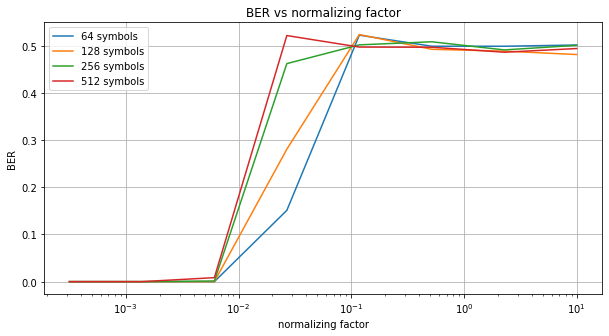

In [3]:
# test the impact of ber vs normalization factor for multiple n_symbols
ssf = SplitStepFourier(
    alpha=0,
    b2=-20e-27,
    gamma=0.003,
    t0=125e-12*1e-2,
    z_n=100,
    # dt=1e-12*1e3,
    h=500
)
cs = ChannelSimulator(m_qam=16, verbose=False, channel_func=ssf)

num_realisations = 3
us_vec = multi_run.create_us_vec(n_steps=8, min_u=-3.5, max_u=1)
N_symbols_vec = np.array([64, 128, 256, 512])

with np.printoptions(precision=2):
    print(f'normalizing factors are: {us_vec}')

    bers_vec, legends = [], []
    for n_sym in N_symbols_vec:
        cs.num_symbols = n_sym
        bers, errs = multi_run.ber_vs_us(cs, us_vec, n_realisations=num_realisations)
        print(f'{n_sym} symbols: errors found = {errs} / [{cs.length_of_msg * num_realisations} '
              f'= {cs.length_of_msg} bits * {num_realisations} realisations]')
        bers_vec.append(bers)
        legends.append(f'{n_sym} symbols')

Visualizer.plot_bers(us_vec, bers_vec, legends)